# モジュールのロード

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# データのロード

In [2]:
tf_flowers = tfds.image_classification.TFFlowers()
tf_flowers.download_and_prepare()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
(train_ds, test_ds) = tf_flowers.as_dataset(as_supervised=True, split=['train[:70%]', 'train[70%:]'], shuffle_files=True)

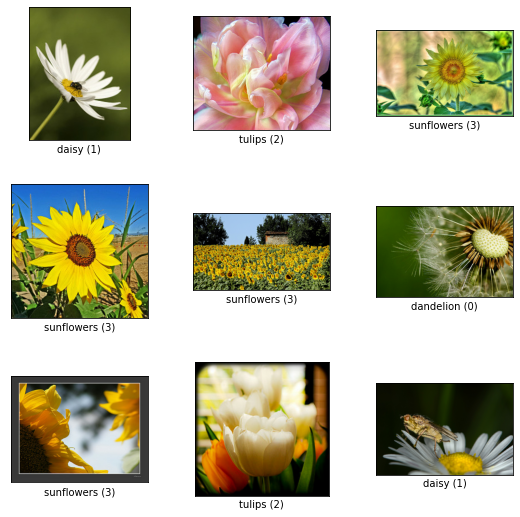

In [4]:
fig = tfds.show_examples(train_ds, tf_flowers.info)

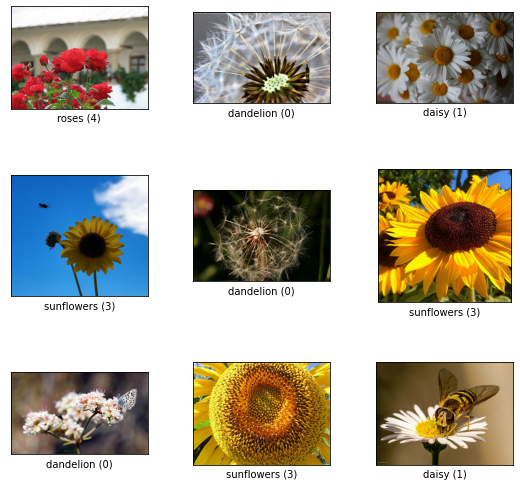

In [5]:
fig = tfds.show_examples(test_ds, tf_flowers.info)

In [6]:
class_num = tf_flowers.info.features['label'].num_classes
class_num

5

In [7]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    label = tf.one_hot(label, depth=class_num)

    return image, label

BATCH_SIZE = 16

train_batches = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(test_batches)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


# 事前学習なしでResNetを利用する

In [8]:
resnet = tf.keras.applications.resnet.ResNet50(weights=None)
resnet.trainable = True
x1 = resnet.layers[-2].output # avg_poolまでのoutputを取得します。
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1) # avg_poolから出力層に繋げます。
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
histories = []

In [10]:
EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 [==============================] - 102s 436ms/step - loss: 1.4234 - acc: 0.4360 - val_loss: 5.9342 - val_acc: 0.2352
Epoch 2/20
161/161 [==============================] - 66s 410ms/step - loss: 1.2245 - acc: 0.5251 - val_loss: 7.0579 - val_acc: 0.2352
Epoch 3/20
161/161 [==============================] - 66s 413ms/step - loss: 1.1517 - acc: 0.5360 - val_loss: 3.4435 - val_acc: 0.2761
Epoch 4/20
161/161 [==============================] - 67s 413ms/step - loss: 1.0655 - acc: 0.5773 - val_loss: 1.3299 - val_acc: 0.5341
Epoch 5/20
161/161 [==============================] - 67s 414ms/step - loss: 0.9832 - acc: 0.6220 - val_loss: 1.5000 - val_acc: 0.5595
Epoch 6/20
161/161 [==============================] - 69s 429ms/step - loss: 0.8742 - acc: 0.6676 - val_loss: 1.6144 - val_acc: 0.5513
Epoch 7/20
161/161 [==============================] - 67s 414ms/step - loss: 0.7891 - acc: 0.7030 - val_loss: 1.5500 - val_acc: 0.5277


# ImageNetによる事前学習を利用する(Weightを再利用、事前学習部分は固定)

In [11]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet')
resnet.trainable = False
x1 = resnet.layers[-2].output # avg_poolまでのoutputを取得します。
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1) # avg_poolから出力層に繋げます。
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [12]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 [==============================] - 32s 174ms/step - loss: 1.6070 - acc: 0.2736 - val_loss: 1.5930 - val_acc: 0.2616
Epoch 2/20
161/161 [==============================] - 27s 165ms/step - loss: 1.5711 - acc: 0.2947 - val_loss: 1.5671 - val_acc: 0.3043
Epoch 3/20
161/161 [==============================] - 27s 166ms/step - loss: 1.5484 - acc: 0.3200 - val_loss: 1.5470 - val_acc: 0.3106
Epoch 4/20
161/161 [==============================] - 27s 165ms/step - loss: 1.5307 - acc: 0.3406 - val_loss: 1.5313 - val_acc: 0.3206
Epoch 5/20
161/161 [==============================] - 27s 165ms/step - loss: 1.5167 - acc: 0.3573 - val_loss: 1.5187 - val_acc: 0.3224
Epoch 6/20
161/161 [==============================] - 27s 165ms/step - loss: 1.5054 - acc: 0.3640 - val_loss: 1.5085 - val_acc: 0.3333
Epoch 7/20
161/161 [==============================] - 27s 166ms/step - loss: 1.4960 - acc: 0.3690 - val_loss: 1.4999 - val_acc: 0.3415
Epoch 8/20
161/161 [==============================] - 2

# ImageNetによる事前学習を利用する(ファインチューニングあり)

In [13]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet')
resnet.trainable = True
x1 = resnet.layers[-2].output
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1)
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [14]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 [==============================] - 74s 419ms/step - loss: 0.4652 - acc: 0.8357 - val_loss: 3.4942 - val_acc: 0.1644
Epoch 2/20
161/161 [==============================] - 67s 413ms/step - loss: 0.0594 - acc: 0.9852 - val_loss: 2.3198 - val_acc: 0.1889
Epoch 3/20
161/161 [==============================] - 66s 412ms/step - loss: 0.0153 - acc: 0.9969 - val_loss: 2.2070 - val_acc: 0.2470
Epoch 4/20
161/161 [==============================] - 67s 413ms/step - loss: 0.0082 - acc: 0.9981 - val_loss: 1.4453 - val_acc: 0.5377
Epoch 5/20
161/161 [==============================] - 69s 430ms/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.6863 - val_acc: 0.7902
Epoch 6/20
161/161 [==============================] - 66s 412ms/step - loss: 7.1122e-04 - acc: 1.0000 - val_loss: 0.2920 - val_acc: 0.9101
Epoch 7/20
161/161 [==============================] - 66s 413ms/step - loss: 3.8559e-04 - acc: 1.0000 - val_loss: 0.1929 - val_acc: 0.9410
Epoch 8/20
161/161 [===========================

# それぞれの学習曲線を確認する

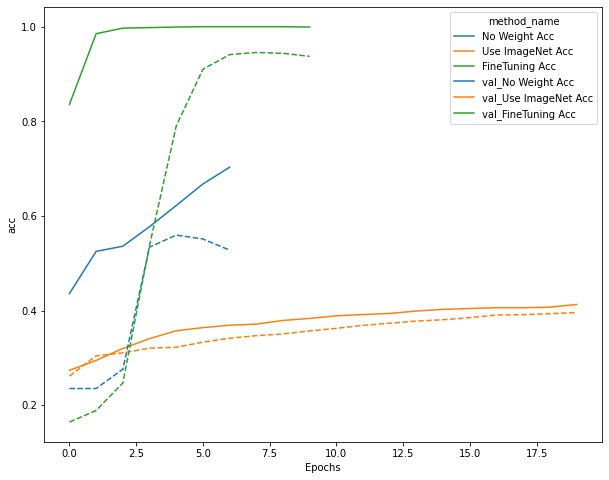

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
method_names = [
                'No Weight Acc',
                'Use ImageNet Acc',
                'FineTuning Acc'
]

plot_df = pd.DataFrame()

for i, history in enumerate(histories):
    method_name = str(method_names[i])
    history_df = pd.DataFrame(history.history)
    history_df['method_name'] = method_name
    history_df['Epochs'] = history_df.index
    plot_df = pd.concat([plot_df, history_df], ignore_index= True)
    
sns.lineplot(data=plot_df, x=plot_df['Epochs'], y='acc', hue='method_name')
val_plot_df = plot_df
val_plot_df['method_name'] = plot_df['method_name'].apply(lambda x: 'val_' + x)
sns.lineplot(data=val_plot_df, x=plot_df['Epochs'], y='val_acc', hue='method_name', linestyle='dashed')